In [ ]:
# Importing necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

In [ ]:
# Opening file, reading, eliminating whitespaces, and splitting by '\n', which in turn creates list
labels = open(r'C:\Users\hp\yolo\coco.names').read().strip().split('\n')  # list of names

# # Check point
# print(labels)

In [ ]:
# Defining paths to the weights and configuration file with model of Neural Network
weights_path = r'C:\Users\hp\yolo\yolov3.weights'
configuration_path = r'C:\Users\hp\yolo\YOLO\yolov3.cfg'

# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.5

# Setting threshold for non-Maximum suppression
threshold = 0.3

In [ ]:
network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)

# Getting names of all layers
layers_names_all = network.getLayerNames()  # list of layers' names

# # Check point
# print(layers_names_all)

In [ ]:
# Getting only output layers' names that we need from YOLO algorithm
indices = network.getUnconnectedOutLayers()
layers_names_output = [layers_names_all[idx - 1] for idx in indices]  # list of layers' names

# Check point
print(layers_names_output)  # ['yolo_82', 'yolo_94', 'yolo_106']

['yolo_82', 'yolo_94', 'yolo_106']


In [ ]:
# Our image initially is in RGB format
# But now we open it in BGR format as function 'cv2.imread' opens it so
image_input = cv2.imread(r'C:\Users\hp\yolo\image2.jpeg')

# Getting image shape
image_input_shape = image_input.shape

# Check point
print(image_input_shape)  # tuple of (917, 1222, 3)

(761, 1140, 3)


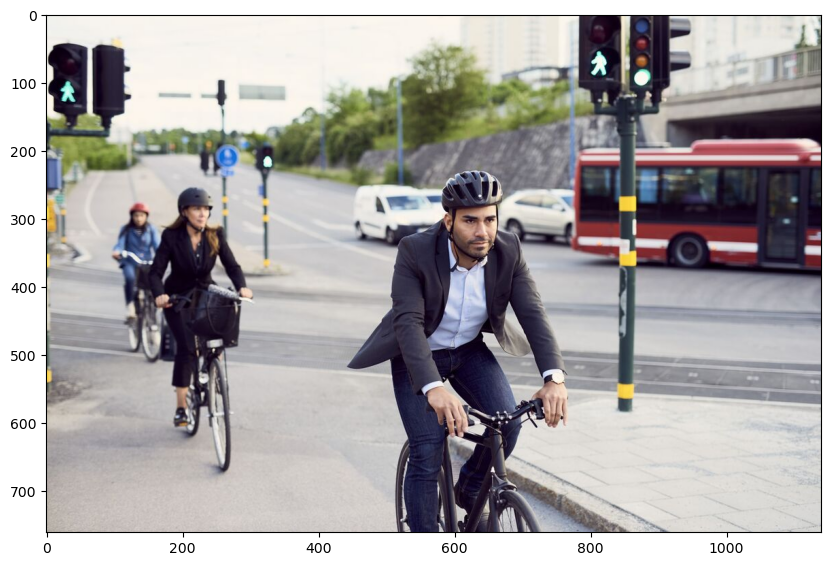

In [ ]:
# Showing RGB image but firstly converting it from BGR format
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# The 'cv2.dnn.blobFromImage' function returns 4-dimensional blob
# from input image after mean subtraction, normalizing, and RB channels swapping
# Resulted shape has number of images, number of channels, width and height
# E.G.: blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size, mean, swapRB=True)
# Link: https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# Check point
print(image_input.shape)  # (917, 1222, 3)
print(blob.shape)  # (1, 3, 416, 416)

(761, 1140, 3)
(1, 3, 416, 416)


(416, 416, 3)


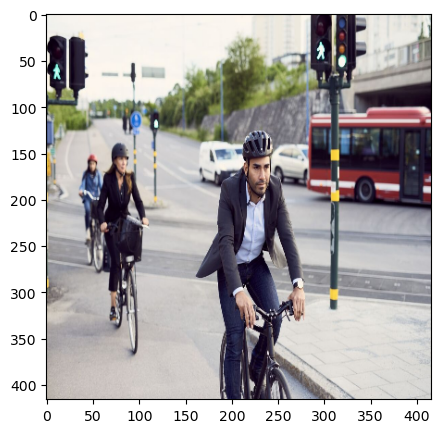

In [ ]:
# Check point
# Slicing blob and transposing to make channels come at the end
blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_to_show.shape)  # (416, 416, 3)

# Showing 'blob_to_show'
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(blob_to_show)
plt.show()

In [ ]:
# Calculating at the same time, needed time for forward pass
network.setInput(blob)  # setting blob as input to the network
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

# Showing spent time for forward pass
print('YOLO v3 took {:.5f} seconds'.format(end - start))

YOLO v3 took 3.54834 seconds


In [ ]:
# Check point
print(type(output_from_network))  # <class 'list'>
print(type(output_from_network[0]))  # <class 'numpy.ndarray'>

<class 'tuple'>
<class 'numpy.ndarray'>


In [ ]:
# Seed the generator - every time we run the code it will generate by the same rules
# In this way we can keep specific colour the same for every class
np.random.seed(42)
# randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Check point
print(colours.shape)  # (80, 3)
print(colours[0])  # [102 220 225]

(80, 3)
[102 220 225]


In [ ]:
# Preparing lists for detected bounding boxes, obtained confidences and class's number
bounding_boxes = []
confidences = []
class_numbers = []

In [ ]:
# Getting spacial dimension of input image
h, w = image_input_shape[:2]  # Slicing from tuple only first two elements

# Check point
print(h, w)  # 917 1222

761 1140


In [ ]:
for result in output_from_network:
    # Going through all detections from current output layer
    for detection in result:
        # Getting class for current object
        scores = detection[5:]
        class_current = np.argmax(scores)

        # Getting confidence (probability) for current object
        confidence_current = scores[class_current]

        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial image size
            # YOLO data format keeps center of detected box and its width and height
            # That is why we can just elementwise multiply them to the width and height of the image
            box_current = detection[0:4] * np.array([w, h, w, h])

            # From current box with YOLO format getting top left corner coordinates
            # that are x_min and y_min
            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

In [ ]:
# It is needed to make sure the data type of the boxes is 'int'
# and the type of the confidences is 'float'
# https://github.com/opencv/opencv/issues/12789
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

# Check point
# Showing labels of the detected objects
for i in range(len(class_numbers)):
    print(labels[int(class_numbers[i])])

# Saving found labels
with open('found_labels.txt', 'w') as f:
    for i in range(len(class_numbers)):
        f.write(labels[int(class_numbers[i])])

bus
bus
bus
bus
bus
person
person
person
person
bicycle
traffic light
traffic light
traffic light
traffic light
traffic light
car
car
car
car
car
car
car
car
car
person
person
person
person
person
person
person
person
bicycle
person
bicycle
bicycle
bicycle
bicycle
person
traffic light
bicycle


In [ ]:
# Checking if there is at least one detected object
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Getting current bounding box coordinates
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        # Preparing colour for current bounding box
        colour_box_current = [int(j) for j in colours[class_numbers[i]]]

        # Drawing bounding box on the original image
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),
                      colour_box_current, 5)

        # Preparing text with label and confidence for current bounding box
        text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])], confidences[i])

        # Putting text with label and confidence on the original image
        cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, colour_box_current, 5)

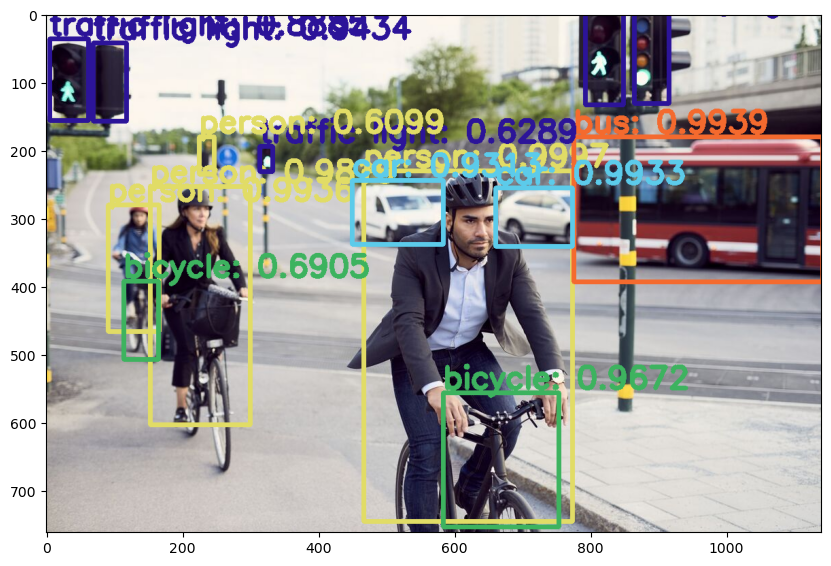

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()